In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.preprocessing import sequence

from TransformerComplet import *

from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, Concatenate, MultiHeadAttention


In [3]:
# Chargement du jeu de données
data = pd.read_csv("../../data/BenignAndMaliciousDataset.csv")

In [4]:
print(data.columns)

Index(['Domain', 'DNSRecordType', 'MXDnsResponse', 'TXTDnsResponse',
       'HasSPFInfo', 'HasDkimInfo', 'HasDmarcInfo', 'Ip', 'DomainInAlexaDB',
       'CommonPorts', 'CountryCode', 'RegisteredCountry', 'CreationDate',
       'LastUpdateDate', 'ASN', 'HttpResponseCode', 'RegisteredOrg',
       'SubdomainNumber', 'Entropy', 'EntropyOfSubDomains',
       'StrangeCharacters', 'TLD', 'IpReputation', 'DomainReputation',
       'ConsoantRatio', 'NumericRatio', 'SpecialCharRatio', 'VowelRatio',
       'ConsoantSequence', 'VowelSequence', 'NumericSequence',
       'SpecialCharSequence', 'DomainLength', 'Class'],
      dtype='object')


In [5]:
print(data.dtypes)


Domain                   int64
DNSRecordType           object
MXDnsResponse             bool
TXTDnsResponse            bool
HasSPFInfo                bool
HasDkimInfo               bool
HasDmarcInfo              bool
Ip                       int64
DomainInAlexaDB           bool
CommonPorts               bool
CountryCode             object
RegisteredCountry       object
CreationDate             int64
LastUpdateDate           int64
ASN                      int64
HttpResponseCode         int64
RegisteredOrg           object
SubdomainNumber          int64
Entropy                  int64
EntropyOfSubDomains      int64
StrangeCharacters        int64
TLD                     object
IpReputation              bool
DomainReputation          bool
ConsoantRatio          float64
NumericRatio           float64
SpecialCharRatio       float64
VowelRatio             float64
ConsoantSequence         int64
VowelSequence            int64
NumericSequence          int64
SpecialCharSequence      int64
DomainLe

In [6]:
# Sélectionner les colonnes numériques
numerical_features = data.select_dtypes(include=['int64', 'float64'])
print("Variables numériques :")
print(numerical_features.columns)

# Sélectionner les colonnes catégorielles
categorical_features = data.select_dtypes(include=['object'])
print("Variables catégorielles :")
print(categorical_features.columns)
boolean_features = data.select_dtypes(include=['bool'])
print("Variables booléennes :")
print(boolean_features.columns)

Variables numériques :
Index(['Domain', 'Ip', 'CreationDate', 'LastUpdateDate', 'ASN',
       'HttpResponseCode', 'SubdomainNumber', 'Entropy', 'EntropyOfSubDomains',
       'StrangeCharacters', 'ConsoantRatio', 'NumericRatio',
       'SpecialCharRatio', 'VowelRatio', 'ConsoantSequence', 'VowelSequence',
       'NumericSequence', 'SpecialCharSequence', 'DomainLength', 'Class'],
      dtype='object')
Variables catégorielles :
Index(['DNSRecordType', 'CountryCode', 'RegisteredCountry', 'RegisteredOrg',
       'TLD'],
      dtype='object')
Variables booléennes :
Index(['MXDnsResponse', 'TXTDnsResponse', 'HasSPFInfo', 'HasDkimInfo',
       'HasDmarcInfo', 'DomainInAlexaDB', 'CommonPorts', 'IpReputation',
       'DomainReputation'],
      dtype='object')


In [7]:
############# les features important ont deja ete calculer avec le gain d'info ,ration le gini index, le coef de correlation #####
############# Nous avons inclus les variable booleenne dans les variable categoricielle ##################
############# On peu leurs transformer sous forme numerique en 0 et 1 mais bon #####


# Séparer les caractéristiques numériques et catégorielles


X_numerical = data[['Domain', 'Ip', 'CreationDate', 'LastUpdateDate', 'ASN',
       'SubdomainNumber', 'StrangeCharacters', 'ConsoantRatio', 'NumericRatio',
       'VowelRatio','NumericSequence']]

y = data['Class']

X_categorical = data[['DNSRecordType', 'CountryCode','RegisteredCountry', 'RegisteredOrg','TXTDnsResponse','HasSPFInfo']]


In [8]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

#prepocessing des features numeriques soit  avec le  LabelEncoder soit le MinMaxScaler()

# Création d'un scaler
scaler = MinMaxScaler()

# Ajustement du scaler aux données
scaler.fit(X_numerical)

# Transformation des fonctionnalités numériques
scaled_numeric_features = scaler.transform(X_numerical)

In [9]:
# Apres transformation Création d' un DataFrame à partir des valeurs transformées

scaled_df = pd.DataFrame(scaled_numeric_features, columns=X_numerical.columns)

# Afficher le DataFrame avec les valeurs transformées
print("Après transformation")
print(scaled_df)

total_size = scaled_df.shape

print("Taille totale des caracteristiques numeriques apres concatenations :", total_size)

Après transformation
         Domain        Ip  CreationDate  LastUpdateDate       ASN   
0      0.049501  1.000000           0.0             0.0  0.000000  \
1      0.049512  1.000000           0.0             0.0  0.000000   
2      0.049523  1.000000           0.0             0.0  0.000000   
3      0.049534  1.000000           0.0             0.0  0.000000   
4      0.049545  1.000000           0.0             0.0  0.000000   
...         ...       ...           ...             ...       ...   
89995  0.840687  1.000000           0.0             0.0  0.000000   
89996  0.609373  1.000000           0.0             0.0  0.000000   
89997  0.791509  1.000000           0.0             0.0  0.000000   
89998  0.922166  0.454722           1.0             1.0  0.117071   
89999  0.717797  1.000000           0.0             0.0  0.000000   

       SubdomainNumber  StrangeCharacters  ConsoantRatio  NumericRatio   
0                  0.0           0.088710            0.6         0.125  \
1 

In [10]:
from sklearn.impute import SimpleImputer

# Vérification des colonnes vides
if X_categorical.isnull().any().any():
    # Imputer les valeurs manquantes pour les caractéristiques catégorielles
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    X_categorical_imputed = pd.DataFrame(categorical_imputer.fit_transform(X_categorical), columns=X_categorical.columns)

    # Afficher le DataFrame avec les valeurs imputées
    print("Après imputation")
    print(X_categorical_imputed)

    total_size_categorical = X_categorical_imputed.shape

    print("Taille totale des caractéristiques catégorielles après imputation :", total_size_categorical)
    print(X_categorical_imputed)
else:
    print("Pas de valeurs manquantes dans les caractéristiques catégorielles. Aucune imputation nécessaire.")


Après imputation
      DNSRecordType CountryCode RegisteredCountry   RegisteredOrg   
0                 A          US                DE  SERVEPATH-BLK2  \
1                 A          US                DE  SERVEPATH-BLK2   
2                 A          US                DE  SERVEPATH-BLK2   
3                 A          US                DE  SERVEPATH-BLK2   
4                 A          US                DE  SERVEPATH-BLK2   
...             ...         ...               ...             ...   
89995             A          US                DE  SERVEPATH-BLK2   
89996             A          US                DE  SERVEPATH-BLK2   
89997             A          US                DE  SERVEPATH-BLK2   
89998             A          US                DE      HGBLOCK-10   
89999             A          US                DE  SERVEPATH-BLK2   

      TXTDnsResponse HasSPFInfo  
0              False      False  
1              False      False  
2              False      False  
3              Fal

In [11]:
all_data_categorical_imputed = X_categorical.columns.tolist()

print(all_data_categorical_imputed)

['DNSRecordType', 'CountryCode', 'RegisteredCountry', 'RegisteredOrg', 'TXTDnsResponse', 'HasSPFInfo']


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd

# Créer une copie du DataFrame pour éviter SettingWithCopyWarning
X_copy = X_categorical_imputed.copy()


# Appliquer une tokenisation à chaque colonne catégorielle
for feature in all_data_categorical_imputed:
    X_copy[feature] = X_copy[feature].astype(str)

#Avec le separator les donnee ne sont pas bien combinée il y'a  les tokens vide et la longueur max c'est 1 d'ou c'est pas bon    
  
X_copy['combined_text'] = X_copy[all_data_categorical_imputed].apply(lambda row: ' '.join(row), axis=1)

#Avec le separator les donnee ne sont pas bien combinée il y'a  les tokens vide et la longueur max c'est 1 d'ou c'est pas bon    

tokenizer = Tokenizer(num_words=100, filters=' ', split=' ')
tokenizer.fit_on_texts(X_copy['combined_text'])
tokens = tokenizer.texts_to_sequences(X_copy['combined_text'])


print([len(seq) for seq in tokens])

#je garde les les sequences

seq_l = [len(seq) for seq in tokens]


# Calcul de la longueur maximale du vecteur
max_sequence_length = max(len(seq) for seq in tokens)

# Affichage de la longueur maximale
print(f"Longueur maximale du vecteur : {max_sequence_length}")


[6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

In [13]:
# Calculer la taille du vocabulaire réel
vocab_size = len(tokenizer.word_index) + 1  # Ajoutez 1 pour tenir compte du padding

# Afficher la taille du vocabulaire
print("Taille réelle du vocabulaire:", vocab_size)

Taille réelle du vocabulaire: 4485


In [15]:
#Calcule des statistique descriptive sur les longueur des sequences

seq_lengths = seq_l

mean_length = np.mean(seq_lengths)
max_length = np.max(seq_lengths)
min_length = np.min(seq_lengths)
std_dev = np.std(seq_lengths)


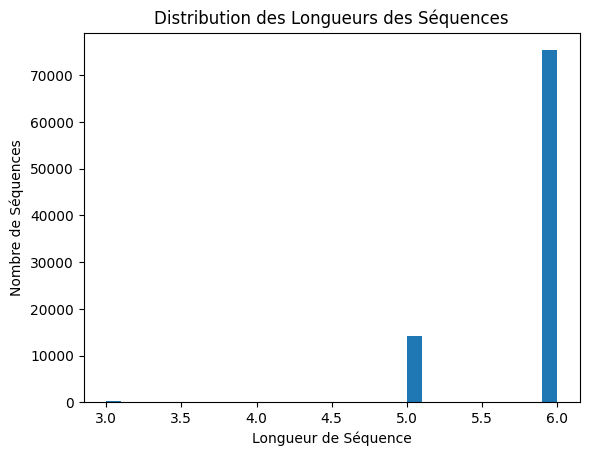

In [16]:
# Visualisation de la distribution des longueurs des séquences
import matplotlib.pyplot as plt
plt.hist(seq_lengths, bins=30)
plt.xlabel('Longueur de Séquence')
plt.ylabel('Nombre de Séquences')
plt.title('Distribution des Longueurs des Séquences')
plt.show()


In [17]:
# Hyperparamètres et dimensions des données*
taille_num_features = scaled_df.shape[1]
taille_text_features = max_sequence_length # je donne la taille max parmi les longueur des sequences
vocab_size = vocab_size #20000  
embedding_dim = 128  

In [18]:
from tensorflow.keras.layers import *
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam

taille_num_features = taille_num_features  # Ajuster selon les données
taille_text_features = taille_text_features  # Ajuster selon les données
vocab_size = vocab_size  # Ajuster selon les données
embedding_dim = 512  # Ajuster selon les données

# Entrées
input_num = tf.keras.layers.Input(shape=(taille_num_features,))
input_text = tf.keras.layers.Input(shape=(taille_text_features,))

# Branche numérique - FFN
num_branch = tf.keras.layers.Dense(256, activation='relu')(input_num)
num_branch = tf.keras.layers.BatchNormalization()(num_branch)
num_branch = tf.keras.layers.Dropout(0.3)(num_branch)
num_branch = tf.keras.layers.Dense(128, activation='relu')(num_branch)
num_branch = tf.keras.layers.BatchNormalization()(num_branch)
num_branch = tf.keras.layers.Dropout(0.3)(num_branch)

# Branche textuelle - Embedding + Transformer (Un block)
text_branch = Embedding(vocab_size, embedding_dim, input_length=taille_text_features)(input_text)
mask_inputs = masque_remplissage(input_text)

out_seq = Encodeur(
            n_layers=5,
            d_model=512,
            num_heads=8,
            middle_units=256,
            max_seq_len=taille_text_features)([text_branch, mask_inputs])
out_seq = GlobalAveragePooling1D()(out_seq)
out_seq = Dropout(0.3)(out_seq)

# Fusion des branches
merged = tf.keras.layers.concatenate([num_branch, out_seq])

# Couches supplémentaires après la fusion
merged = tf.keras.layers.Dense(128, activation='relu')(merged)
merged = tf.keras.layers.BatchNormalization()(merged)
merged = tf.keras.layers.Dropout(0.3)(merged)
merged = tf.keras.layers.Dense(64, activation='relu')(merged)
merged = tf.keras.layers.BatchNormalization()(merged)
merged = tf.keras.layers.Dropout(0.3)(merged)
merged = tf.keras.layers.Dense(32, activation='relu')(merged)

output = tf.keras.layers.Dense(1, activation='sigmoid')(merged)

# Création et compilation du modèle
model = Model(inputs=[input_num, input_text], outputs=output)

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())


Instructions for updating:
Colocations handled automatically by placer.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          3072        ['input_1[0][0]']                
                                                                                                  
 tf_op_layer_Equal (TensorFlowO  [(None, 6)]         0           ['input_2[0][0]']                
 pLayer)              

In [ ]:
# from tensorflow.keras.layers import *
# import tensorflow as tf



# # Entrées
# input_num = tf.keras.layers.Input(shape=(taille_num_features,))
# input_text = tf.keras.layers.Input(shape=(taille_text_features,))

# # Branches du modèle
# # Branche numérique - FFN

# num_branch = tf.keras.layers.Dense(64, activation='relu')(input_num)
# num_branch = tf.keras.layers.Dense(32, activation='relu')(num_branch)



# # Branche textuelle - Embedding + Transformer (Un block)

# text_branch = Embedding(vocab_size, embedding_dim, input_length=taille_text_features)(input_text)

# mask_inputs = masque_remplissage(input_text) 

# out_seq = Encodeur(
#             n_layers=4,
#             d_model=128,
#             num_heads=2,
#             middle_units=256,
#             max_seq_len=taille_text_features)([text_branch, mask_inputs])
# out_seq = GlobalAveragePooling1D()(out_seq)
# out_seq = Dropout(0.3)(out_seq)

# ################## reduction des dimensionalite apres soris de l'encodeur #############


# # Réduction de dimension pour la sortie de l'encodeur
# reduction_dim = tf.keras.layers.Dense(32, activation='relu')(out_seq)
# # Concaténation des sorties réduites de dimension et de la branche numérique
# merged = tf.keras.layers.concatenate([num_branch, reduction_dim])


# # Fusion des branches 

# flattened_text_branch = tf.keras.layers.Flatten()(text_branch) # je remodelise les dimension
# merged = tf.keras.layers.concatenate([num_branch, flattened_text_branch])

# # merged = layers.add([num_branch, text_branch])
# # merged = layers.subtract([num_branch, text_branch])
# # merged = layers.multiply([num_branch, text_branch])

# # Couches supplémentaires après la fusion
# merged = tf.keras.layers.Dropout(0.3)(merged)
# merged = tf.keras.layers.Dense(16, activation='relu')(merged)

# output = tf.keras.layers.Dense(1, activation='sigmoid')(merged)

# from tensorflow.keras.optimizers.legacy import Adam

# # tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

# # Création et compilation du modèle
# model = Model(inputs=[input_num, input_text], outputs=output)
# opt = Adam(learning_rate=0.0001)

# model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# print(model.summary())



In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Entrées pour l'entraînement
data_num = scaled_numeric_features  
# data_text = np.array(tokens)  
data_text = pad_sequences(tokens, maxlen=max_length,padding='post')



In [22]:
# Assurez-vous que les données numériques sont correctes
print("Shape of data_num:", data_num.shape)

# Assurez-vous que les données textuelles sont correctes après le rembourrage
print("Shape of data_text:", data_text.shape)

# Assurez-vous que les étiquettes sont correctes
print("Shape of labels:", y.shape)

# NB utiliser le resultat obtenu pour modifier les tailles ou dimension de mes entrées definie plus haut



Shape of data_num: (90000, 11)
Shape of data_text: (90000, 6)
Shape of labels: (90000,)


In [23]:
#maintenant on va divisser les donnee en deux [entrainenemt et text]

from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
text_train, text_test, num_train, num_test, labels_train, labels_test = train_test_split(
    data_text, data_num, y, test_size=0.2, random_state=42
)

In [24]:
print("Shape of text_train:", text_train.shape)
print("Shape of labels_train:", labels_train.shape)
print("Shape of text_test:", text_test.shape)
print("Shape of labels_test:", labels_test.shape)
print("Shape of num_train:", num_train.shape)
print("Shape of num_test:", num_test.shape)

print("Visualisation des dimension et du batch_size\n")

batch_size, dimension = text_train.shape[0], text_train.shape[1]
print("Batch size text train:", batch_size)
print("Dimension text train:", dimension)

batch_size, dimension = num_train.shape[0], num_train.shape[1]
print("Batch size num train:", batch_size)
print("Dimension num train:", dimension)



Shape of text_train: (72000, 6)
Shape of labels_train: (72000,)
Shape of text_test: (18000, 6)
Shape of labels_test: (18000,)
Shape of num_train: (72000, 11)
Shape of num_test: (18000, 11)
Visualisation des dimension et du batch_size

Batch size text train: 72000
Dimension text train: 6
Batch size num train: 72000
Dimension num train: 11


In [25]:
history = model.fit([num_train,text_train], labels_train, epochs=20, batch_size=64, validation_data=([num_test,text_test], labels_test))


Train on 72000 samples, validate on 18000 samples
Epoch 1/20
72000/72000 [==============================] - ETA: 0s - loss: 0.0487 - accuracy: 0.9826

c:\python install\lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


72000/72000 [==============================] - 935s 13ms/sample - loss: 0.0487 - accuracy: 0.9826 - val_loss: 0.0057 - val_accuracy: 0.9986
Epoch 2/20
72000/72000 [==============================] - 931s 13ms/sample - loss: 0.0070 - accuracy: 0.9984 - val_loss: 0.0040 - val_accuracy: 0.9993
Epoch 3/20
72000/72000 [==============================] - 1098s 15ms/sample - loss: 0.0061 - accuracy: 0.9986 - val_loss: 0.0035 - val_accuracy: 0.9991
Epoch 4/20
72000/72000 [==============================] - 926s 13ms/sample - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.0031 - val_accuracy: 0.9993
Epoch 5/20
72000/72000 [==============================] - 1009s 14ms/sample - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.0024 - val_accuracy: 0.9992
Epoch 6/20
72000/72000 [==============================] - 929s 13ms/sample - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.0026 - val_accuracy: 0.9993
Epoch 7/20
72000/72000 [==============================] - 918s 13ms/sample - loss: 0.0044 - accuracy: 0

In [26]:
#on effectue les prediction sur les donnees de test

y_pred = model.predict([num_test,text_test])

print(y_pred)

c:\python install\lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


[[3.7531612e-05]
 [1.0000000e+00]
 [1.0000000e+00]
 ...
 [1.0000000e+00]
 [1.3490566e-06]
 [1.0000000e+00]]


In [27]:
# necessaire pour afficher la matrix de confusion car a besoin que la probabilité retourner pqr lq fonction sigmoid soir saoit 0 ou 1 pour travailler dessus

y_pred = np.round(y_pred)

In [28]:
# Évaluation du modèle sur les données de test
evaluation_results = model.evaluate([num_test, text_test], labels_test)
# loss, accuracy = model.evaluate([num_test, text_test], labels_test)


# Affichage des résultats

# print(f'Accuracy: {accuracy}, Loss: {loss}')
print("Perte sur les données de test:", evaluation_results[0])
print("Précision sur les données de test:", evaluation_results[1])


Perte sur les données de test: 0.001499046165369186
Précision sur les données de test: 0.9995555


In [29]:
from sklearn.metrics import classification_report,accuracy_score


# Afficher le rapport de classification
class_report = classification_report(labels_test, y_pred)
print("Rapport de classification :\n", class_report)


Rapport de classification :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8854
           1       1.00      1.00      1.00      9146

    accuracy                           1.00     18000
   macro avg       1.00      1.00      1.00     18000
weighted avg       1.00      1.00      1.00     18000



In [30]:
# Extraction des métriques d'entraînement
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Affichage des courbes de perte et d'exactitude séparément
epochs = range(1, len(loss) + 1)

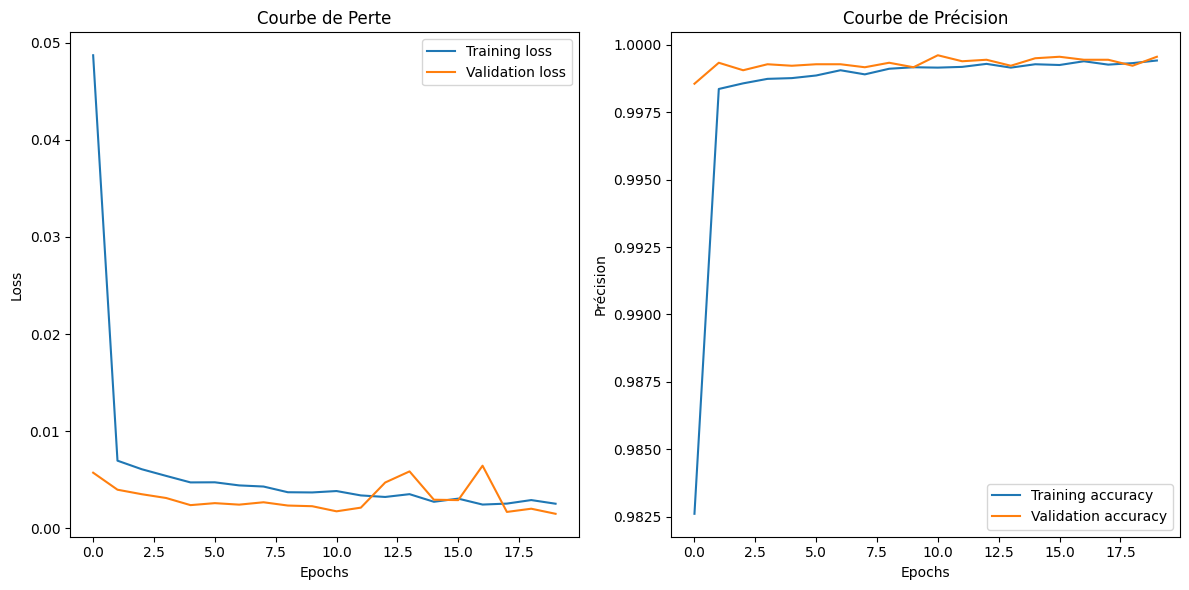

In [31]:
# Affichage des courbes d'apprentissage et de validation
plt.figure(figsize=(12, 6))

# Plot de la perte d'entraînement et de la perte de validation
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Courbe de Perte')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot de la précision d'entraînement et de la précision de validation
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Courbe de Précision')
plt.xlabel('Epochs')
plt.ylabel('Précision')
plt.legend()

# Afficher les deux sous-plots
plt.tight_layout()
plt.show()

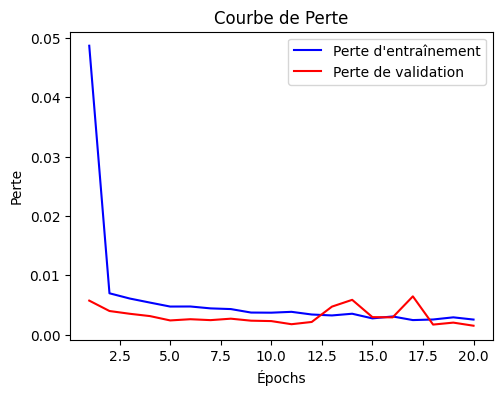

In [32]:
#je separe les schema individuellement pour une bonne lisibileté

# Courbe de perte
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Perte d\'entraînement')
plt.plot(epochs, val_loss, 'r', label='Perte de validation')
plt.title('Courbe de Perte')
plt.xlabel('Épochs')
plt.ylabel('Perte')
plt.legend()

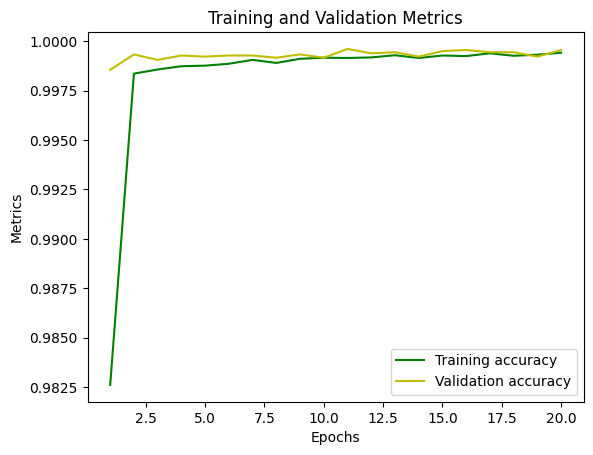

In [33]:
# Courbe de perte

plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'y', label='Validation accuracy')
plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

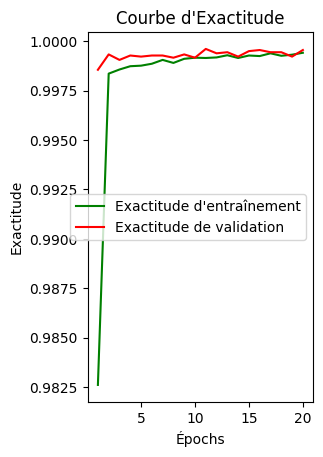

In [34]:
# Courbe d'exactitude
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'g', label='Exactitude d\'entraînement')
plt.plot(epochs, val_accuracy, 'r', label='Exactitude de validation')
plt.title('Courbe d\'Exactitude')
plt.xlabel('Épochs')
plt.ylabel('Exactitude')
plt.legend()

plt.show()

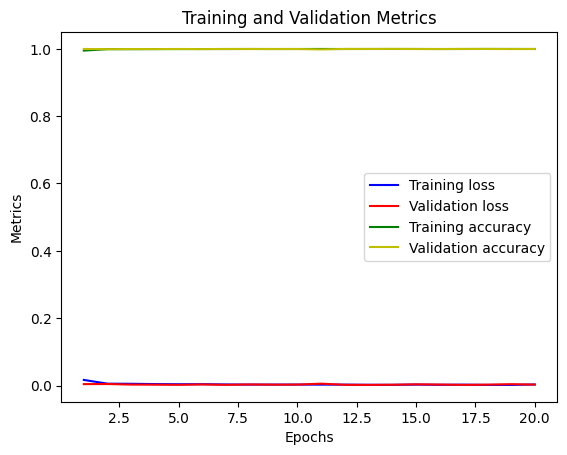

In [49]:
# je use une courbe pour afficher tout les 4 courbes

# Afficher les courbes
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'y', label='Validation accuracy')
plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

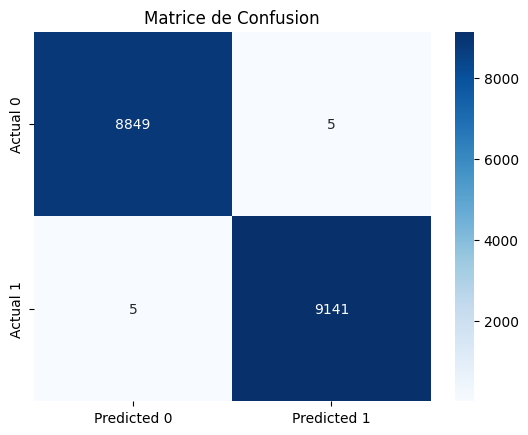

In [50]:
#affichage de la matrixe de confusion

import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix


#calul preliminaire pour obtenir la matrice de confusion

conf_matrix = confusion_matrix(labels_test,y_pred)
true_negatives, false_positives,false_negatives, true_positives = conf_matrix.ravel()

# Créer la matrice de confusion
conf_matrix = np.array([[true_negatives, false_positives], [false_negatives, true_positives]])

# Afficher la matrice de confusion avec seaborn
df_cm = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.title('Matrice de Confusion')
plt.show()


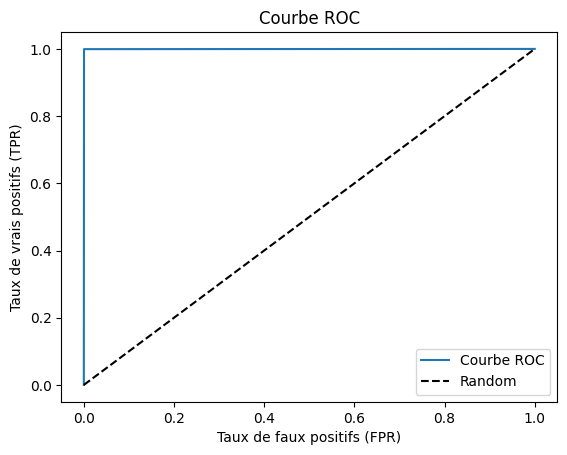

Aire sous la courbe (AUC) : 0.9994461011492851


In [93]:
#Courbe de ROC

from sklearn.metrics import roc_curve, roc_auc_score

# Calcul des taux FPR et TPR
fpr, tpr, thresholds = roc_curve(labels_test, y_pred)

# Plotter la courbe ROC
plt.plot(fpr, tpr, label='Courbe ROC')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend()
plt.show()

# Calcul de l'AUC
auc = roc_auc_score(labels_test, y_pred)
print('Aire sous la courbe (AUC) :', auc)
